<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/Attention-models/Xception/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Working with Xception**

In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import os
import math
import gc
import threading

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate, Conv2DTranspose, Lambda
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling2D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import spectral

np.random.seed(1337)          # to get reproducible results
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Xception"

In [ ]:
# The line of code will run only if we are using gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   print("GPU not found")
else:
   print('Found GPU at : ', device_name)

Found GPU at :  /device:GPU:0


In [ ]:
H, W, B = 1101, 566, 372             # height,width and band of image
# keep ps=7 in this file
P_S = 7            # patch size (window size)
use_pearson_corr = True
train_percent = 75
epochs = 100

In [ ]:
mat_x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']           # shape 623166*372
mat_y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']     # shape 623166*1

x, y = np.array(mat_x), np.array(mat_y)
x, y = x.reshape(H,W,B), y.reshape(H,W)

x = x.astype('float16')
for i in range(B):
  x[:,:,i] /= np.max(x[:,:,i])

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

output_classes = len(np.unique(y))-1

In [ ]:
x_train, x_test, y_train, y_test = train_test_split( X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 668,  128,  192,  337,  259,  174,  753,  181,  190,  404, 1033,
        404, 1163]))


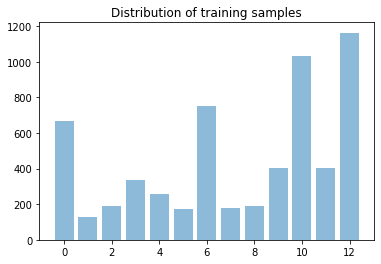

In [ ]:
u_c = np.unique(y_train,return_counts=True)
print(u_c)
plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
plt.title('Distribution of training samples')
plt.show()
del u_c

In [ ]:
# del un-necessary data as it is consuming around 3 GB of RAM
# Note memory, runtime, accuracy is everything in Data Science
del mat_x, mat_y, x, y, X, Y

## **Defining Functions**

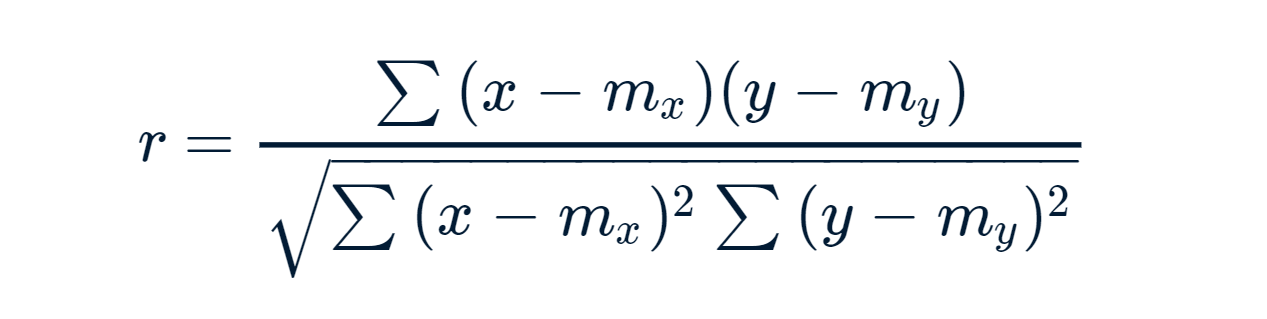

In [ ]:
def masked_correlation(gus_k, X, channels = 64, P_S = 11):
    loc = P_S//2
# Working as per the above formula to calculate Pearson correlation coefficient.
# For all the operations I have avoided any kind of loop as loops are slow (written in python). Numpy array (written in C) and Tensors are very fast.
# Here we are interested to use highly correlated spatial information around central pixels. we will consider the surrounding spatial information based on their correlation

    x_mean = tf.math.reduce_mean(X, axis = -1, keepdims=True)
    x_mean = tf.repeat(x_mean, repeats = channels, axis = -1)

    y = X[:,loc:loc+1, loc:loc+1, :]
    y = tf.repeat(y, repeats = P_S, axis = -2)
    y = tf.repeat(y, repeats = P_S, axis = -3)

    y_mean = tf.math.reduce_mean(y, axis = -1, keepdims = True)
    y_mean = tf.repeat(y_mean, repeats = channels, axis = -1)

    a = tf.math.subtract(X, x_mean)
    b = tf.math.subtract(y, y_mean)
    ab = tf.math.multiply(a,b)
    num = tf.math.reduce_sum(ab, axis = -1, keepdims = True)                        # Numerator

    a_new = tf.math.reduce_sum(tf.math.multiply(a,a), axis = -1, keepdims = True)
    b_new = tf.math.reduce_sum(tf.math.multiply(b,b), axis = -1, keepdims = True)
    deno = tf.math.sqrt(tf.math.multiply(a_new, b_new))                             # Denominator
 
    corr = tf.math.divide(num, deno)                                                # Pearson correlation coefficient

    thresh = tf.math.reduce_mean(corr)                                      # Consider the surrounding spatial info showing correlation value higher than a certain threshold.
    mask = corr > thresh                                                    # Forming a mask for selecting spatial information [1 if to select otherwise 0 ]
    mask = tf.cast(mask, corr.dtype)

    masked_corr = tf.math.multiply(mask, corr)
    # gus_k = tf.expand_dims(gus_k, axis = -1) 
    # gus_k = gus_k.reshape(P_S, P_S, 1)                     
    # masked_corr = tf.math.multiply(masked_corr, gus_k)          # Further scaling the selected spatial information based on their distance from centre (apply gaussion filter)
  
    attention_weights = tf.repeat(masked_corr, repeats = channels, axis = -1)
    X = Multiply()([X, attention_weights])
    return X

In [ ]:
def Spatial_attention_0(x, filter):
    shape = x.shape
    x = Conv2D(filters=1, kernel_size=(1,1), padding='same')(x) # to aggregate the Spatial information. Generating 2D feature map.
    x = BatchNormalization()(x)
    # Applying 2D convolution to derive a spatial attention.
    x = Conv2D(filters=1, kernel_size=(7,7), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(5,5), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(3,3), padding='same')(x)
    x = Activation('sigmoid')(x) 
    # x = Conv2D(filters = filter, kernel_size=(1,1), kernel_initializer=Ones())(x)
    x = tf.repeat(x, repeats = filter, axis = -1)
    # Sigmoid is used as activation so that pixel with very less information can be converted to nearby zero and highly important to nearly 1
    # Further multiplication with initial spatial features will keep highly important features and minimize the others less important features to zero (approx)
    return x

def Spatial_attention(x, filter):
    input = x
    shape = x.shape
    # x = Conv2D(filters=filter, kernel_size=(1,1), padding='same')(x)
    # x = BatchNormalization()(x)
    # Applying 2D convolution to derive a spatial attention.
    x = Conv2D(filters=filter, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)     # kernel_regularizer=l2(5e-4)
    x = BatchNormalization(axis=-1)(x)
    x_0 = Activation('relu')(x)

    x = Conv2D(filters=filter, kernel_size=(3,3), strides = (2,2), padding='same')(x_0)
    x = Activation('relu')(x)

    x = Conv2D(filters=1, kernel_size=(3,3), strides = (2,2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    if shape != x.shape:
        k_size = x.shape[-3] - shape[-3] + 1
        x = Conv2D(filter, kernel_size=k_size, strides=(1, 1), padding='valid')(x)
    else:
        pass
    x = Activation('sigmoid')(x) 
    # x = Conv2D(filters = filter, kernel_size=(1,1), kernel_initializer=Ones())(x)
    # x = tf.repeat(x, repeats = filter, axis = -1)
    # Sigmoid is used as activation so that pixel with very less information can be converted to nearby zero and highly important to nearly 1
    # Further multiplication with initial spatial features will keep highly important features and minimize the others less important features to zero (approx)
    # x = Multiply()([input, x])
    # x = add([output, input])
    return x

In [ ]:
def channel_attention_block(input, filters, kernel_size, padding, reduction_ratio, weight_decay=5e-4):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_initializer='he_normal')(input)    # kernel_regularizer=l2(weight_decay)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    squeeze = GlobalAveragePooling2D(keepdims=True)(x)

    # excitation = Reshape((1, 1, filters))(squeeze)
    excitation = Conv2D(filters=filters//reduction_ratio, kernel_size=1, use_bias=False, kernel_initializer='he_normal')(squeeze)
    excitation = Activation('relu')(excitation)
    excitation = Conv2D(filters=filters, kernel_size=1, use_bias=False, kernel_initializer='he_normal')(excitation)
    excitation = Activation('sigmoid')(excitation)

    # x = multiply([input, excitation])

    # x_add = add([x, input])

    return excitation
 
def Spectral_attention(input, filters, cardinality = 8):
    shape = input.shape
    group_list = []
    grouped_channels = shape[-1]//cardinality        # As some bands/channels may be more important than their neighbours and at the same time less important than distants.
    for c in range(cardinality):                     # We will consider band importance in their neighbours (generate subsets of bands and then apply attention)
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels])(input)
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(1, 1), kernel_initializer='he_normal')(x)
        x_channel = channel_attention_block(x, filters=grouped_channels, kernel_size=3, padding='same', reduction_ratio=2)
        group_list.append(x_channel)

    group_merge = concatenate(group_list, axis=-1)
    x = BatchNormalization(axis=-1)(group_merge)
    x = UpSampling2D(size=(shape[1], shape[2]))(x) # Upsample the array to match the origional feature metrix
    return x

def Spectral_attention_0 (x, filters):
    shape = x.shape
    # Averagepooling the features along channel. (shape = 1*1*channels or bands). 1D vector representing bands info.
    # Now we have 1 value per channel/band. After training we would have high value in vector corresponding to highly important band.
    x = GlobalAveragePooling2D(data_format='channels_last', keepdims=True)(x)
    x = Conv2D(filters=filters, kernel_size=(1,1))(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=filters, kernel_size=(1,1))(x)
    x = Activation('sigmoid')(x)
    # Sigmoid is used as activation so that value in vector corresponding to different bands can be altered as per their importance.
    x = UpSampling2D(size=(shape[1], shape[2]))(x) # Upsample the array to match the origional feature metrix
    return x

In [ ]:
# def apply_attention(X, Spe_A, Spa_A):
#     F_A = Multiply()([X, Spe_A])  # Multiplication operation will generate scaled output based on Spectral importance
#     F_B = Multiply()([X, Spa_A])  # Multiplication operation will generate scaled output based on Spatial importance
#         # X = Add()([X, F_A, F_B])      # Adding all the output(convolution, Spectral, Spatial) from the block
#     X = Add()([F_A, F_B])
#     X = BatchNormalization()(X)
#     return X

In [ ]:
def conv_block(x, filters):
    # conv-BN-relu
    x = Conv2D(filters, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
def separable_conv_block(x, filters, pre_activation=None):
    if pre_activation is True:
        x = Activation('relu')(x)
    # (relu)-sepconv-BN-(relu)
    x = SeparableConv2D(filters, (3,3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    if pre_activation is False:
        x = Activation('relu')(x)
    return x

In [ ]:
def middle_flow_block(x, filters):
    # middle flow
    residual = x
    x = separable_conv_block(x, filters, pre_activation=True)
    x = separable_conv_block(x, filters, pre_activation=True)
    x = separable_conv_block(x, filters, pre_activation=True)
    return Add()([x, residual])

In [ ]:
def xception_block(x, filters, pre_activation=True):
    filter_conv1, filter_conv2 = filters
    # residual conv branch
    residual = Conv2D(filter_conv2, (1, 1), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    # separable conv block
    x = separable_conv_block(x, filter_conv1, pre_activation=pre_activation)
    x = separable_conv_block(x, filter_conv2, pre_activation=True)

    return Add()([x, residual])

In [ ]:
def Xception(input_shape=(P_S,P_S,B), use_attention=True, use_pearson_corr = True, classes = 13):
    img_input = Input(shape=input_shape)
    #===========ENTRY FLOW==============
    #Block 1
    if use_pearson_corr:
        x = masked_correlation(None, img_input, channels = B, P_S = P_S)
        x = conv_block(x, 16)
    else:
        x = conv_block(img_input, 16)
    x = conv_block(x, 32)

    if use_attention:
        Spa_A = Spatial_attention(x, 128)                 # Form spatial attention 1 

        #Block 2
        x = xception_block(x, (64, 64), pre_activation=False)
        #Block 3
        x = xception_block(x, (128, 128))
        #===========MIDDLE FLOW===============
        #   for i in range(3):

        x = middle_flow_block(x, 128)

        Spe_A = Spectral_attention(x, 128)               # Form spectral attention 1
        F_B = Multiply()([x, Spa_A])                     # Apply spatial attention 1
        x = Add()([x*0.7, F_B*0.3])

        x = middle_flow_block(x, 128)
        x = middle_flow_block(x, 128)
        Spa_A = Spatial_attention(x, 256)                 # Form spatial attention 2

        F_A = Multiply()([x, Spe_A])                    # Apply spectral attention 1
        x = Add()([x*0.7, F_A*0.3])
        
        #========EXIT FLOW============
        #Block 7
        x = xception_block(x, (128, 256)) # second conv is different
        F_B = Multiply()([x, Spa_A])                     # Apply spatial attention 2
        x = Add()([x*0.7, F_B*0.3])


        # Block 8
        x = separable_conv_block(x, 512, pre_activation=False)
        Spe_A = Spectral_attention(x, 512)               # Form spectral attention 2
        F_A = Multiply()([x, Spe_A])                    # Apply spectral attention 1
        x = Add()([x*0.7, F_A*0.3])

    else:
        #Block 2
        x = xception_block(x, (64, 64), pre_activation=False)
        #Block 3
        x = xception_block(x, (128, 128))
        #===========MIDDLE FLOW===============
        for i in range(3):
            x = middle_flow_block(x, 128)
        #========EXIT FLOW============
        #Block 7
        x = xception_block(x, (128, 256)) # second conv is different
        # Block 8
        x = separable_conv_block(x, 512, pre_activation=False)

    # Dense Units
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(classes, activation='softmax')(x)
    # Create model.
    model = Model(inputs=img_input, outputs=x, name='xception')
    return model

In [ ]:
def lrfn(epoch):
    LR_START = 0.03
    LR_MAX = 0.01 
    LR_MIN = 0.001
    LR_RAMPUP_EPOCHS = 0
    LR_SUSTAIN_EPOCHS = 0
    EPOCHS = epoch
    STEPS = [epochs,400]
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

In [ ]:
def build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path, use_pearson_corr = True, use_attention = True, batch_size = 128, epochs = 100, P_S = P_S, B = B):
    # Generating proper directory for saving the model
    if use_attention:
        dir = folder_path + "/With_Attention/"
        print('You are using attention mechanism.......')
###############
# Constructing Gaussian kernel 
        # sig = P_S//2
        # x = np.linspace(-(P_S/2)/sig, (P_S/2)/sig, P_S+1)
        # kern1d = np.diff(st.norm.cdf(x))
        # kern2d = np.outer(kern1d, kern1d)
        # kern2d = kern2d/kern2d.sum()
        # kern2d = kern2d/kern2d.max()
        gus_k = None
###############
    else:
        dir = folder_path + "/Without_Attention/"
        print('You are not using attention mechanism.......')
        gus_k = None
    try:
        os.makedirs(dir)
    except:
        pass
    filepath= dir + str(train_percent) + "% ps_" + str(P_S) + " Xception.hdf5"

    # Building the model
    model = Xception(input_shape=(P_S,P_S,B), use_attention=use_attention, use_pearson_corr = use_pearson_corr, classes = 13)
    plot_model(model, to_file = dir + "model_architecture.jpg", show_shapes=False)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    # Compiling the model
    model.compile(optimizer=optimizers.Adagrad(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('compiling done successfully.......')

    file_dir = os.path.dirname(filepath)
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    # rng = [i for i in range(EPOCHS)]
    # lr_y = [lrfn(x) for x in rng]
    callbacks_list = [checkpoint, lr_callback]

    print('starting the training phase....')
    start_time = time.time()
    history = model.fit(x = x_train, y = y_train, validation_data = (x_test,y_test), validation_freq = 1, batch_size = batch_size, 
                        callbacks=callbacks_list, shuffle = False, epochs=epochs, use_multiprocessing = True)
    end_time = time.time()
    tt = end_time - start_time
    tt_min = tt//60
    tt_sec = tt - tt_min*60
    print(f'model trained ████████████████████████████████████████████████████████████████████████ 100% for {epochs} epochs')
    print('\n')
    print(f'total time taken for training is: {tt_min} min, {tt_sec} sec')
    return model, history, tt

In [ ]:
def plot_accuracy_loss_curve(history, folder_path = None, use_attention = True):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='black', marker='o', linewidth=2, markersize = 3,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=2, markersize = 3, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'pink', marker='o', linewidth=2, markersize = 3, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=2, markersize = 3, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        if use_attention:
            dir = folder_path + "/With_Attention/"
        else:
            dir = folder_path + "/Without_Attention/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + "accuracy_loss_curve.jpg"
        fig.savefig(path)

In [ ]:
def plot_comparision_plot(history, history_att, train_or_val = 'train', folder_path = None):  # Can be used to compare 2 models
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    df = pd.DataFrame({'train_loss' : train_loss,
                    'val_loss' : val_loss,
                    'train_accuracy' : train_accuracy,
                    'val_accuracy': val_accuracy})
    
    train_loss = history_att.history['loss']
    val_loss = history_att.history['val_loss']
    train_accuracy = history_att.history['accuracy']
    val_accuracy = history_att.history['val_accuracy']

    df_att = pd.DataFrame({'train_loss' : train_loss,
                    'val_loss' : val_loss,
                    'train_accuracy' : train_accuracy,
                    'val_accuracy': val_accuracy})

    fig = plt.figure(figsize=(24,10))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(df[train_or_val + '_accuracy'], color='black', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_accuracy')
    ax.plot(df_att[train_or_val + '_accuracy'], color='green', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_attention_accuracy')
    # if total_to_plot > 2:
    #     ax.plot(df2[train_or_val + '_accuracy'], color='gray', marker='o', linewidth=2, markersize = 8, label = train_or_val + '_accuracy_2')
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(df[train_or_val + '_loss'], color = 'pink', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_loss')
    ax2.plot(df_att[train_or_val+'_loss'], color = 'red', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_attention_loss')
    # if total_to_plot > 2:
    #     ax2.plot(df2[train_or_val + '_loss'], color = 'orange', marker='o', linewidth=2, markersize = 8, label = train_or_val + 'train_loss_2')
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance on ' + train_or_val + ' score')
    ax2.legend()
    plt.show()

    if folder_path:
        dir = folder_path + "/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + train_or_val + " comparision_plot.jpg"
        fig.savefig(path)
    # return fig



In [ ]:
def predict(model, x_test):
    y_pred = model.predict(x_test)
    y_pred1 = np.zeros((y_pred.shape[0],1))
    for a in range(y_pred.shape[0]):
        y_pred1[a] = np.argmax(y_pred[a])
    y_pred = y_pred1
    del y_pred1
    return y_pred

In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    pad_width = int((P_S-1)/2)
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))

    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def performance_meausures(y_test, y_pred, tt, use_attention, folder_path = None, P_S = P_S):
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "training time: " : tt}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2,
                            width_ratios=[1,3], wspace = 0.5,
                            hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,8))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    if folder_path:
        if use_attention:
            dir = folder_path + "/With_Attention/"
        else:
            dir = folder_path + "/Without_Attention/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + str(train_percent) + "% ps_" + str(P_S) + " Performance.jpg"
        fig.savefig(path)

In [ ]:
def reload_model(folder_path, use_attention, P_S = P_S):
    if use_attention:
        path = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " Xception.hdf5"
    else:
        path = folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " Xception.hdf5"
    model = load_model(path)
    return model

## **Attention Model**

In [ ]:
use_attention = True
use_pearson_corr = True
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Xception"

In [ ]:
model_att, history_att, tt = build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path = folder_path, 
                                               use_pearson_corr = use_pearson_corr, use_attention = use_attention, batch_size = 128, epochs = 100, P_S = P_S, B = B)

You are using attention mechanism.......
compiling done successfully.......
starting the training phase....

Epoch 1: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 1.5926 - accuracy: 0.5817
Epoch 1: val_accuracy improved from -inf to 0.19766, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Xception/With_Attention/75% ps_7 Xception.hdf5
46/46 [==============================] - 47s 168ms/step - loss: 1.5926 - accuracy: 0.5817 - val_loss: 2.5267 - val_accuracy: 0.1977 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009997734440724333.
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.8498 - accuracy: 0.7311
Epoch 2: val_accuracy improved from 0.19766 to 0.19918, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Xception/With_Atten

In [ ]:
model_att.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 372)]  0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 1, 1, 372)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.repeat_1 (TFOpLambda)       (None, 1, 7, 372)    0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                                                                           

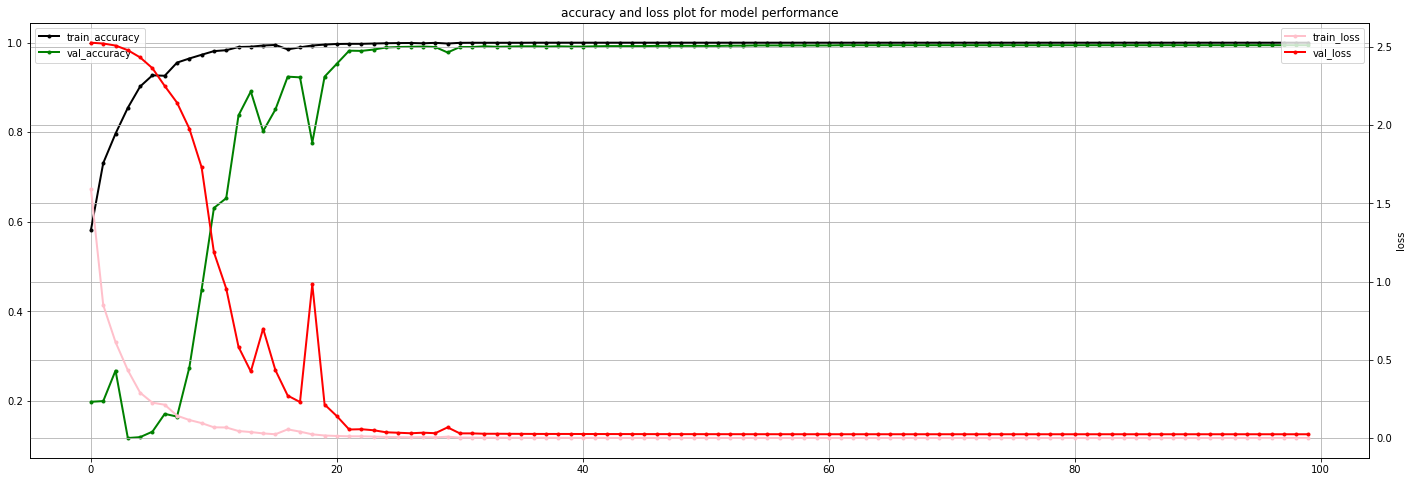

In [ ]:
plot_accuracy_loss_curve(history_att, None, use_attention = use_attention)

In [ ]:
model_path_att = path = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " Xception.hdf5"
model_att = load_model(model_path_att)

In [ ]:
# y_pred = predict(model, x_test)
y_pred = np.argmax(model_att.predict(x_test), axis = 1)

62/62 [==============================] - 3s 17ms/step


In [ ]:
y_pred.shape, y_test.shape

((1963,), (1963,))

In [ ]:
filepath1 = folder_path +"/With_Attention/" + str(train_percent) + "% performance.txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)

 Confusion Matrix : 
[[219   0   0   0   0   0   0   0   0   0   1   0   3]
 [  0  42   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1  63   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 112   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0  87   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  56   1   1   0   0   0   0   0]
 [  0   0   0   0   0   0 251   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  60   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  63   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 135   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 344   0   0]
 [  0   1   0   0   0   0   1   0   0   0   0 133   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 388]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       223
           1       0.95      1.00      0.98        42
           2       1.00      0.98      0.99        64
           3       1.00      0.99 

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)

filepath1 = folder_path +"/With_Attention/"+str(train_percent)+"%_xception_ps"+str(P_S)+".csv"

#img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_SAresnet_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(filepath1, y_combined, delimiter=",")

In [ ]:
import gc
gc.collect()

9350

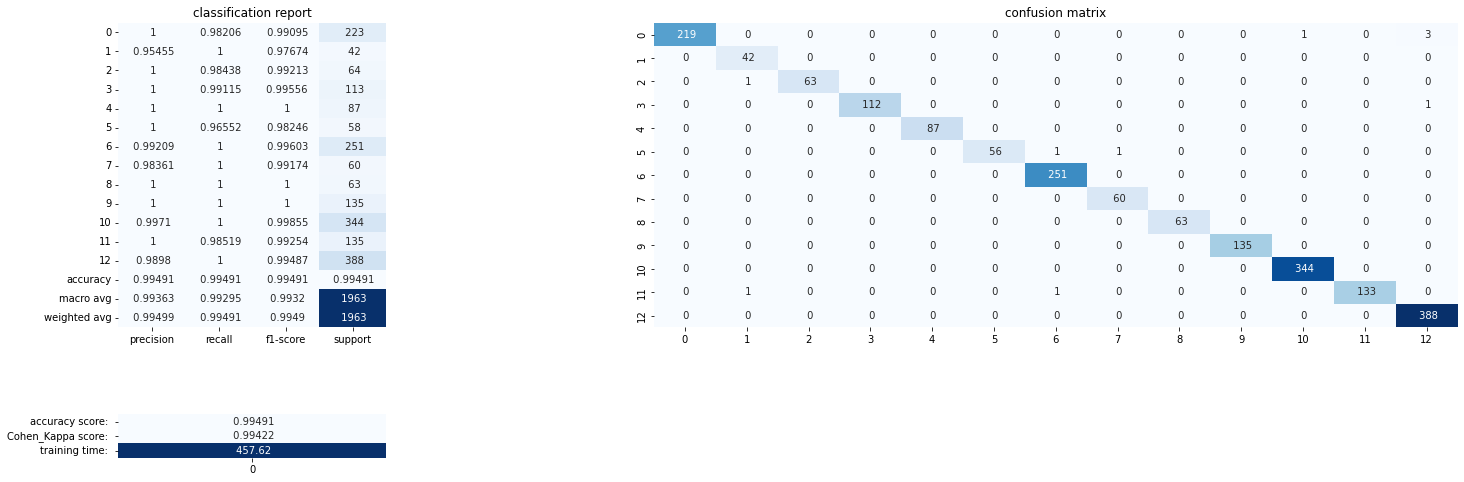

In [ ]:
performance_meausures(y_test, y_pred, tt, use_attention = use_attention, folder_path = folder_path, P_S = P_S)

In [ ]:
y_hat = predict_image(model_att, padded_x, H, W, B, P_S)

y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)

img_path_att = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
spectral.save_rgb(img_path_att, y_hat, colors = spectral.spy_colors)

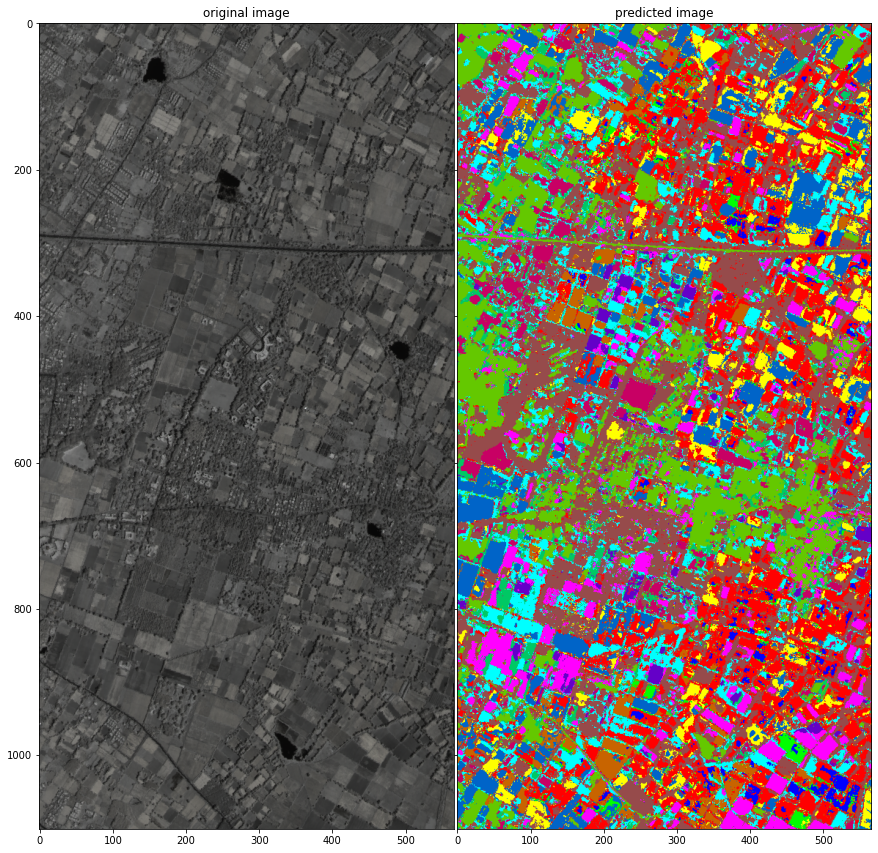

In [ ]:
# img_path_att = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
fig, (ax1, ax2) = plt.subplots(1,2, sharex = True, sharey = True, figsize = (12, 12))
original_image = plt.imread("/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Approximate RGB Image.png")
ax1.imshow(original_image)
ax1.set_title("original image")

img = plt.imread(img_path_att)
ax2.imshow(img)
ax2.set_title("predicted image")
plt.tight_layout(pad = 0, h_pad = 0, w_pad = 0)
plt.show()

## **Without Attention**

In [ ]:
use_attention = False
use_pearson_corr = True
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Xception"

In [ ]:
model, history, tt = build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path = folder_path, use_pearson_corr = use_pearson_corr, 
                                               use_attention = use_attention, batch_size = 128, epochs = epochs)

You are not using attention mechanism.......
compiling done successfully.......
starting the training phase....

Epoch 1: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 1/100
44/46 [===========================>..] - ETA: 0s - loss: 1.4390 - accuracy: 0.5675
Epoch 1: val_accuracy improved from -inf to 0.11360, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Xception/Without_Attention/75% ps_7 Xception.hdf5
46/46 [==============================] - 14s 64ms/step - loss: 1.4177 - accuracy: 0.5734 - val_loss: 2.5444 - val_accuracy: 0.1136 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009997734440724333.
Epoch 2/100
45/46 [============================>.] - ETA: 0s - loss: 0.7526 - accuracy: 0.7599
Epoch 2: val_accuracy did not improve from 0.11360
46/46 [==============================] - 1s 32ms/step - loss: 0.7493 - accuracy: 0.7613 - val_loss: 2.5406 - val_accuracy: 0.1136 

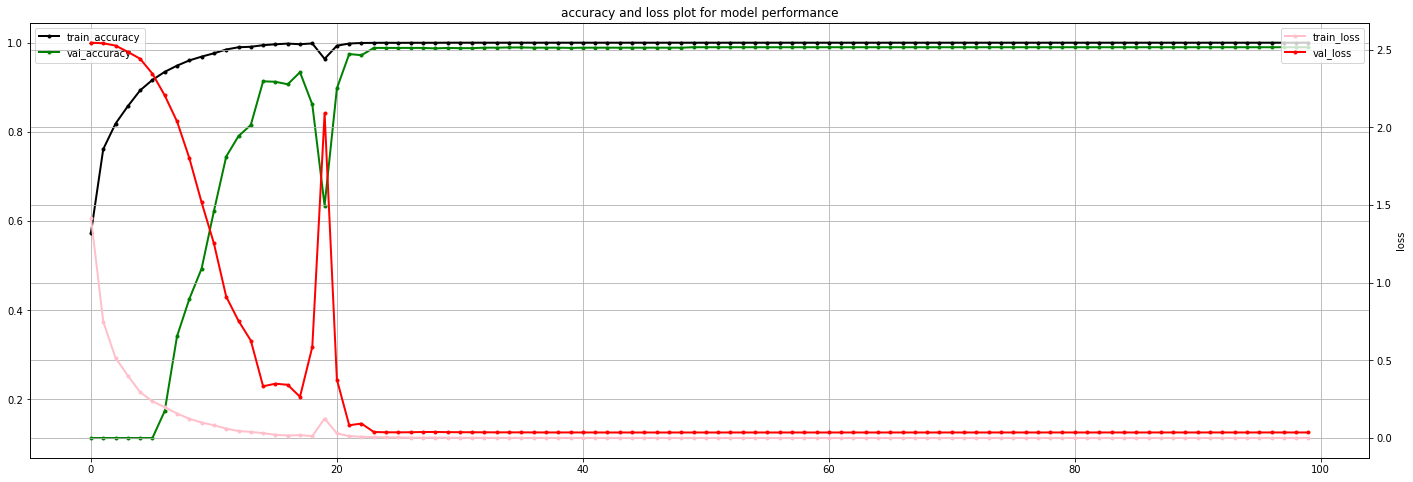

In [ ]:
# df = pd.read_csv(folder_path + "/Without_Attention/history.csv")
plot_accuracy_loss_curve(history, None, use_attention = use_attention)

In [ ]:
model = reload_model(folder_path, use_attention, P_S)

In [ ]:
# y_pred = predict(model, x_test)
y_pred = np.argmax(model.predict(x_test), axis = 1)

62/62 [==============================] - 1s 6ms/step


In [ ]:
filepath1 = folder_path +"/Without_Attention/" + str(train_percent) + "% performance.txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)

 Confusion Matrix : 
[[216   1   0   0   0   0   0   0   0   0   0   0   6]
 [  1  41   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0  62   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0 112   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0  87   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0  54   1   0   1   0   0   0   1]
 [  1   0   0   0   0   0 250   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  60   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  63   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 135   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 344   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0 133   1]
 [  1   0   0   0   0   3   0   0   0   0   0   0 384]]
 Report :  
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       223
           1       0.98      0.98      0.98        42
           2       1.00      0.97      0.98        64
           3       1.00      0.99 

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)

filepath1 = folder_path +"/Without_Attention/"+str(train_percent)+"%_Xception_ps"+str(P_S)+".csv"

#img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_SAresnet_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(filepath1, y_combined, delimiter=",")

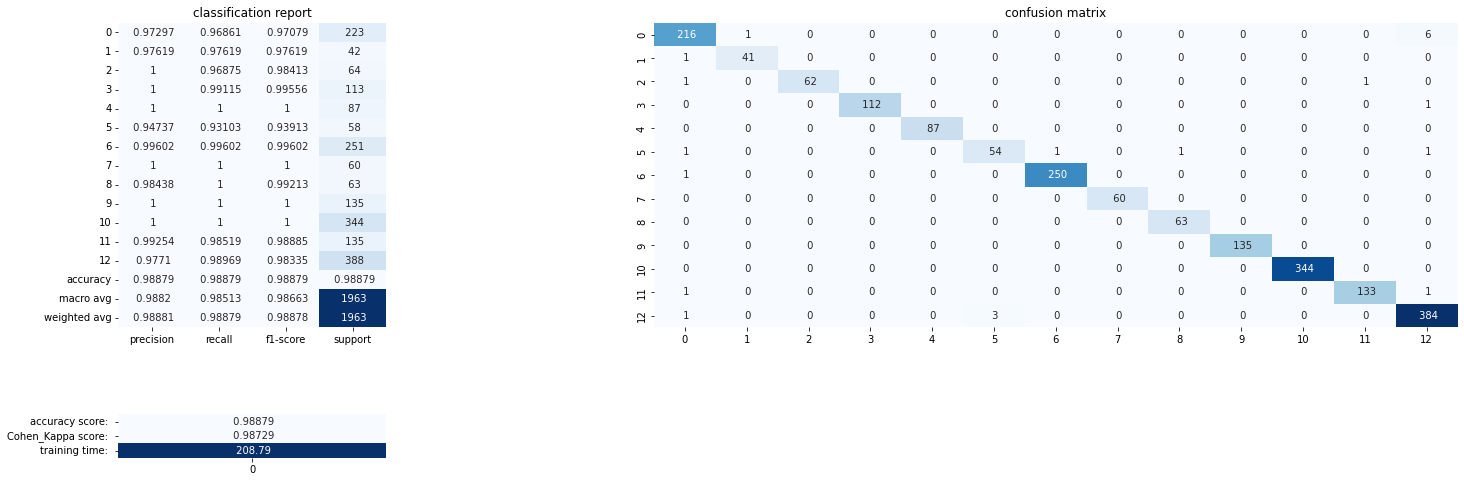

In [ ]:
performance_meausures(y_test, y_pred, tt, use_attention = use_attention, folder_path = folder_path, P_S = P_S)
#print(performance_meausures)

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)

y_hat = y_hat.reshape((H,W))
a_c = np.unique(y_hat,return_counts=True)
print(a_c)

img_path = folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)

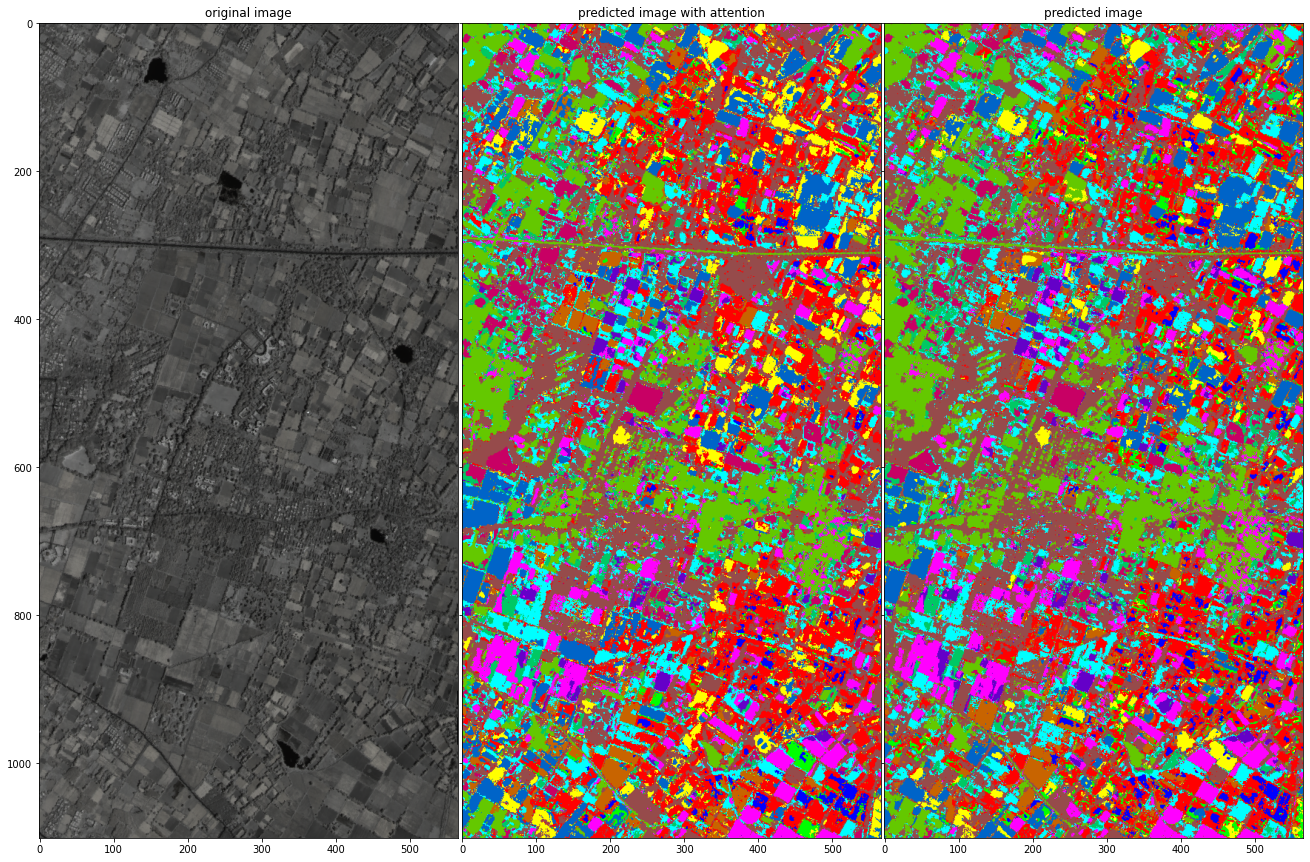

In [ ]:
# img_path = folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex = True, sharey = True, figsize = (18, 12))
original_image = plt.imread("/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Approximate RGB Image.png")
ax1.imshow(original_image)
ax1.set_title("original image")

img = plt.imread(img_path_att)
ax2.imshow(img)
ax2.set_title("predicted image with attention")

img = plt.imread(img_path)
ax3.imshow(img)
ax3.set_title("predicted image")

plt.tight_layout(pad = 0, h_pad = 0, w_pad = 0)
plt.show()

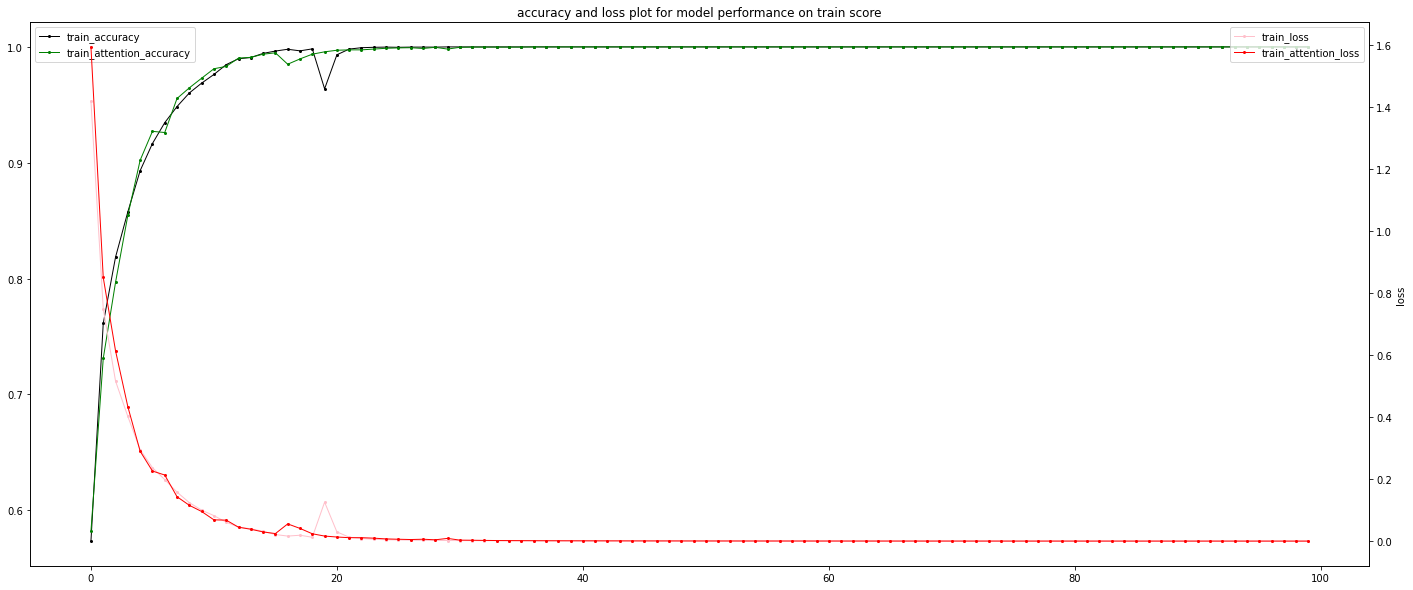

In [ ]:
plot_comparision_plot(history, history_att, train_or_val = 'train', folder_path = None)

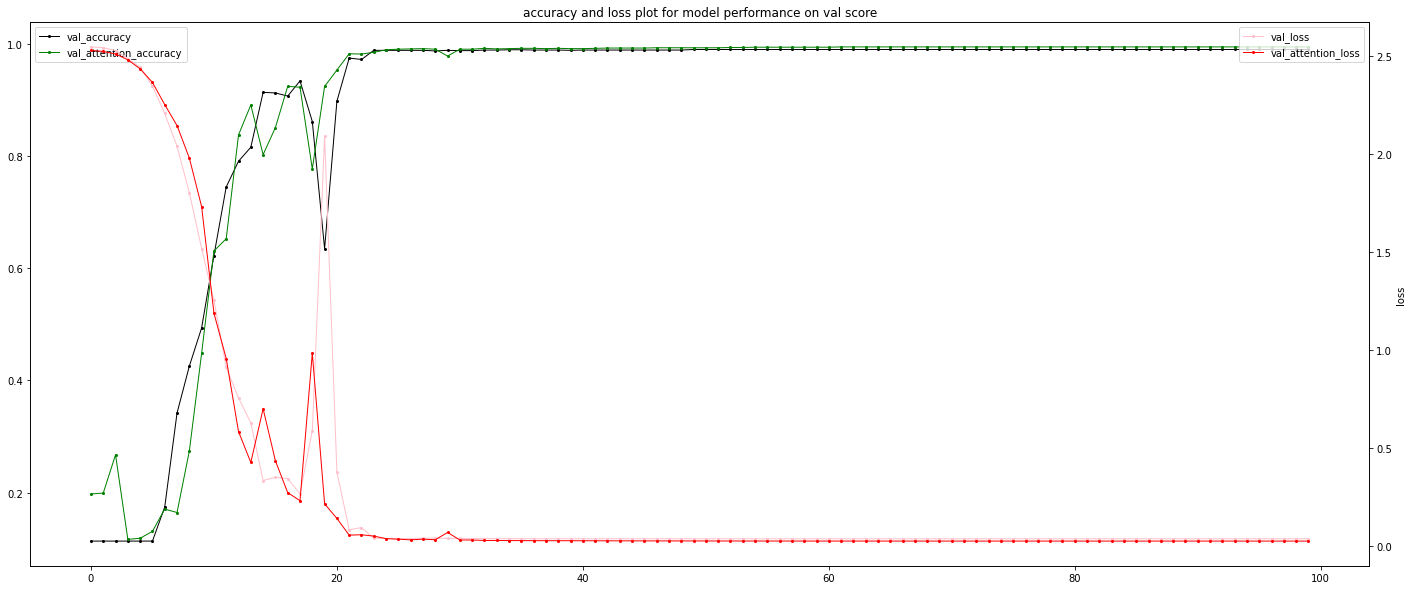

In [ ]:
plot_comparision_plot(history, history_att, train_or_val = 'val', folder_path = None)